<h1><center>IMT2118 - Ciencia de Datos Geoespaciales (2024-1) </center></h1>
<h2><center>Tarea 3:  Percepción Remota y Análisis Espacial de Islas de Carlor Urbanas </center></h2>

### 1. Generación de mapas de temperaturas.

**1.1 [4 ptos]**  De la colección [Landsat 8](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2), obtenga y visualize un raster con la temperatura superficial (LST) media para Santiago, para un mes de la temporada de verano 2022-2023. Utilice unidades de grados Celsius.

He escogido enero de 2023 y he usado los datos de santiago del censo 2017 para bordes.


In [66]:
import pandas as pd
import numpy as np
import geemap,ee
import matplotlib.colors as colors
from shapely.geometry import shape, box
import shapely
from matplotlib import colors
import matplotlib.patches as mpatches
import geemap.colormaps as cm
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import mapping
from libpysal import weights
import esda 
from pykrige.ok import OrdinaryKriging

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-dtperez1')

In [4]:
#Bordes
san = gpd.read_file('Data/PROVINCIA_C17.shp').to_crs(4326)
santiago = san[san['NOM_PROVIN'] == 'SANTIAGO'].geometry

#AOI
minx,miny,maxx,maxy=santiago.to_crs(4326).geometry.total_bounds
xy=[[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy]]
aoi = ee.Geometry.Polygon(xy)

xy_ran = santiago.to_crs(4326)
obj = mapping(xy_ran)
aoi_san = ee.Geometry.Polygon(obj['features'][0]['geometry']['coordinates'])

#Imagenes
collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(aoi).filterDate('2023-01-01','2023-01-31')
images=collection.aggregate_array('system:id').getInfo()

In [5]:
#Escalado (según página de landsat)
def scala(image):
       opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
       thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
       return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True)

scalado = []
for imagen in images:
    scalado.append(scala(ee.Image(imagen)))

#Sacar nubes

def fmask(image):
       qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
       return image.updateMask(qaMask)

sin_nubes = []
for imagen in scalado:
    sin_nubes.append(fmask(ee.Image(imagen)))

collection_sin_nubes = ee.ImageCollection(sin_nubes)

In [6]:
#Escoger capas relevantes
col_rgb = collection_sin_nubes.select(["SR_B4", "SR_B3", "SR_B2", 'SR_B5', 'ST_B10'])
med_co = col_rgb.reduce(ee.Reducer.geometricMedian(5))
med_co = med_co.clip(aoi_san)

#NDVI y sacar temperaturas corregidas según referencia entregada
ndvi = med_co.normalizedDifference(["geometric_median_3","geometric_median_1"]).rename('NDVI')

ndviMin = ee.Number(ndvi.reduceRegion(reducer = ee.Reducer.min(), geometry = aoi_san, scale = 30, maxPixels = 1e9).values().get(0))
ndviMax = ee.Number(ndvi.reduceRegion(reducer = ee.Reducer.max(), geometry = aoi_san, scale = 30, maxPixels = 1e9).values().get(0))

fv = ((ndvi.subtract(ndviMin)).divide(ndviMax.subtract(ndviMin))).pow(ee.Number(2)).rename('FV')

em = fv.multiply(ee.Number(0.004)).add(ee.Number(0.986)).rename('EM')

col_t = ee.ImageCollection(sin_nubes).select('ST_B10')
med_t = col_t.reduce(ee.Reducer.geometricMedian(1))
med_t = med_t.clip(aoi_san)

therm = med_co.select('geometric_median_4').rename('therm')
para = therm.expression(expression = '(TB / (1 + (0.00115 * (TB / 1.438)) * log(em))) - 273.15', opt_map={'TB': therm.select('therm'), 'em': em})

In [7]:
#Colores 
arcoiris = [
    '040274', '040281', '0502a3', '0502b8', '0502ce', '0502e6',
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef',
    '3be285', '3ff38f', '86e26f', '3ae237', 'b5e22e', 'd6e21f',
    'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08', 'ff500d',
    'ff0000', 'de0101', 'c21301', 'a71001', '911003'
  ]

In [8]:
Map = geemap.Map(center=[0.5 * (miny + maxy),0.5 * (minx + maxx)], zoom=10)

vis_params = {"min": 10, "max": 40 , 'palette': arcoiris}

Map.addLayer(para, vis_params,name='Imagen')

Map

Map(center=[-33.362209971499965, -70.56555456249995], controls=(WidgetControl(options=['position', 'transparen…

**1.2 [4 ptos]** Considere a continuación los datos de temperatura generados por la Red de Estaciones Automáticas DGAC-DMC, y publicados por la Dirección Metereológica de Chile en su portal https://climatologia.meteochile.gob.cl/. Para buscar y descargar datos de esta plataforma, es recomendable registrarse como usuario.

He usado 3 estaciones, que eran las que estaban en el aoi.

In [12]:
#Lectura de datos
est_1 = pd.read_csv('data/330019_202301_Temperatura.csv', sep = ';')
est_2 = pd.read_csv('data/330020_202301_Temperatura.csv', sep = ';') 
est_3 = pd.read_csv('data/330114_202301_Temperatura.csv', sep = ';') 

#Limpieza
est_1 = est_1.iloc[:-1 , :]
est_2 = est_2.iloc[:-1 , :]
est_3 = est_3.iloc[:-1 , :]

#Revisar si medición es AM o PM
def mañana(s):
    hora = int(s.split(' ')[1].split(':')[0])
    return hora < 12

est_1['Es AM'] = est_1['momento'].apply(mañana)
est_2['Es AM'] = est_2['momento'].apply(mañana)
est_3['Es AM'] = est_3['momento'].apply(mañana)

#Temperaturas Promedio
t_1_AM = est_1[est_1['Es AM'] == True]['ts'].mean()
t_1_PM = est_1[est_1['Es AM'] == False]['ts'].mean()

t_2_AM = est_2[est_2['Es AM'] == True]['ts'].mean()
t_2_PM = est_2[est_2['Es AM'] == False]['ts'].mean()

t_3_AM = est_3[est_3['Es AM'] == True]['ts'].mean()
t_3_PM = est_3[est_3['Es AM'] == False]['ts'].mean()

Text(0.5, 1.0, 'Promedio temperaturas AM')

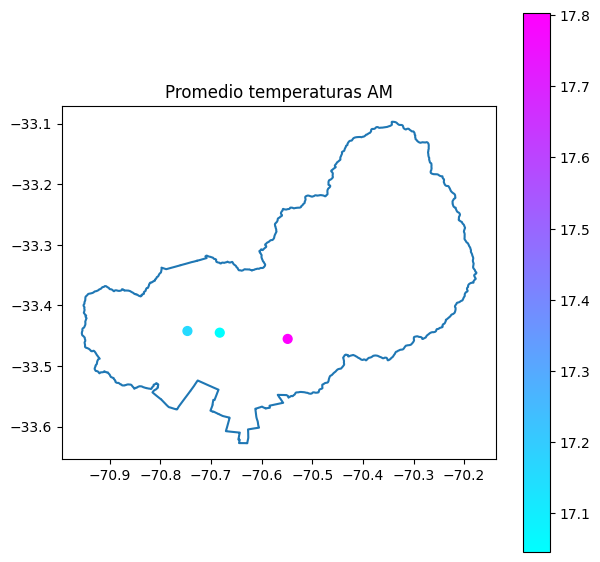

In [117]:
fig=plt.figure(figsize=(7,7))
ax=fig.add_subplot(111)
santiago.boundary.plot(ax=ax)
plt.scatter([-70.548610, -70.682777, -70.746666], [-33.455277, -33.444999, -33.442221],c =[t_1_AM, t_2_AM, t_3_AM] ,cmap='cool', s=40)
plt.colorbar()
ax.set_title('Promedio temperaturas AM')

Text(0.5, 1.0, 'Promedio temperaturas PM')

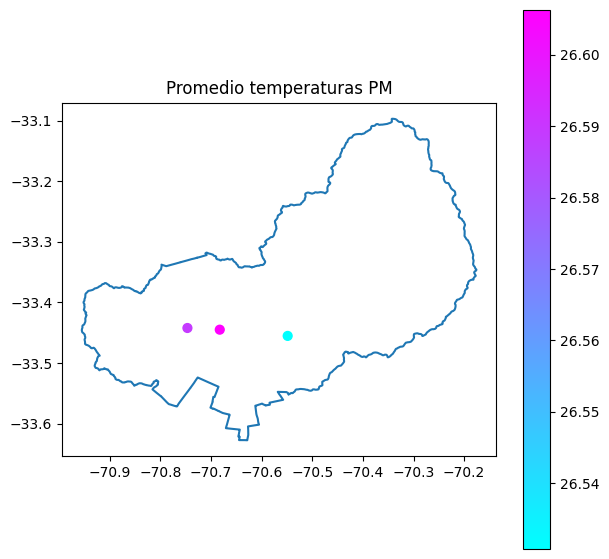

In [113]:
fig=plt.figure(figsize=(7,7))
ax=fig.add_subplot(111)
santiago.boundary.plot(ax=ax)
plt.scatter([-70.548610, -70.682777, -70.746666], [-33.455277, -33.444999, -33.442221],c =[t_1_PM, t_2_PM, t_3_PM] ,cmap='cool', s=40)
plt.colorbar()
ax.set_title('Promedio temperaturas PM')

**1.3 [6 puntos]** A partir de los datos obtenidos en el punto 1.2, genere 3 superficies de interpolación mediante métodos de proximidad, superficie de tendencia y/o Krigging. 

In [162]:
lons = np.array([-70.548610, -70.682777, -70.746666])
lats = np.array([-33.455277, -33.444999, -33.442221])
t_AM = np.array([t_1_AM, t_2_AM, t_3_AM])
t_PM = np.array([t_1_PM, t_2_PM, t_3_PM])

#grilla
xi = np.arange(minx,maxx,0.01)
yi = np.arange(miny,maxy,0.01)
xx, yy = np.meshgrid(xi,yi)

### Kriging

Text(0.5, 1.0, 'Residuos AM')

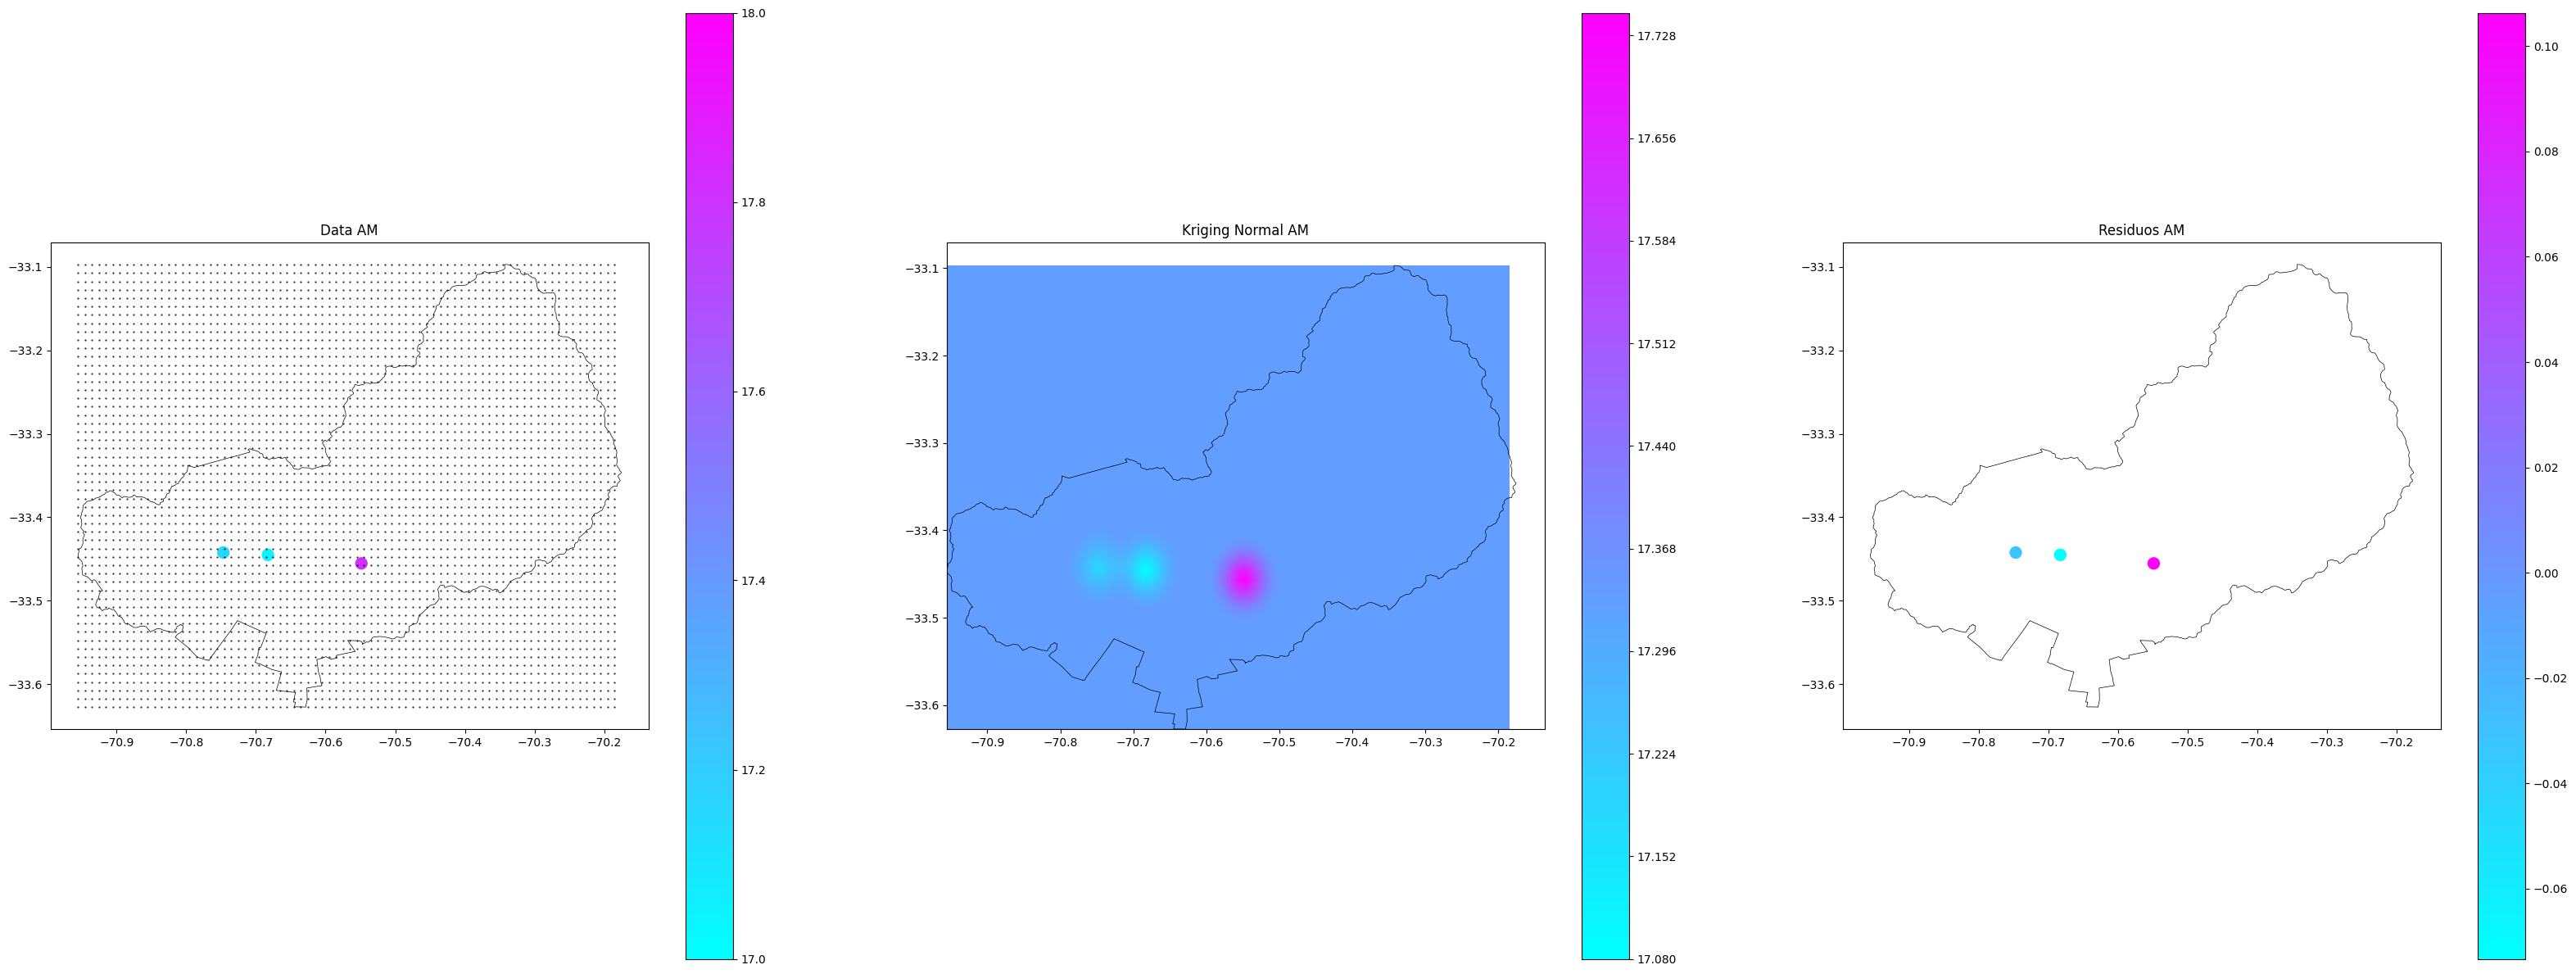

In [237]:
OK = OrdinaryKriging(lons, lats, t_AM, variogram_model='spherical', verbose=False, enable_plotting=False)
z1, ss1 = OK.execute('grid', xi, yi)

residuals = t_AM - np.array([z1.data[17][40], z1.data[18][28], z1.data[18][21]])

fig,(ax0,ax1, ax2)=plt.subplots(1,3,figsize=(40,15))

im=ax0.scatter(lons,lats,c=t_AM,cmap='cool',vmin=17,vmax=18, s = 100)
santiago.boundary.plot(ax=ax0,color='k',lw=0.5)
ax0.plot(xx, yy, marker='.', markersize=1,color='k', linestyle='none')
plt.colorbar(im,ax=ax0)
ax0.set_title('Data AM')

santiago.boundary.plot(ax=ax1,color='k',lw=0.5)
im1=ax1.contourf(xx,yy,z1, 100, cmap='cool', origin='lower')
plt.colorbar(im1,ax=ax1)
ax1.set_title('Kriging Normal AM');

santiago.boundary.plot(ax=ax2,color='k',lw=0.5)
im1=ax2.scatter(lons,lats,c=residuals,cmap='cool', s = 100)
plt.colorbar(im1,ax=ax2)
ax2.set_title('Residuos AM')

Text(0.5, 1.0, 'Residuos PM')

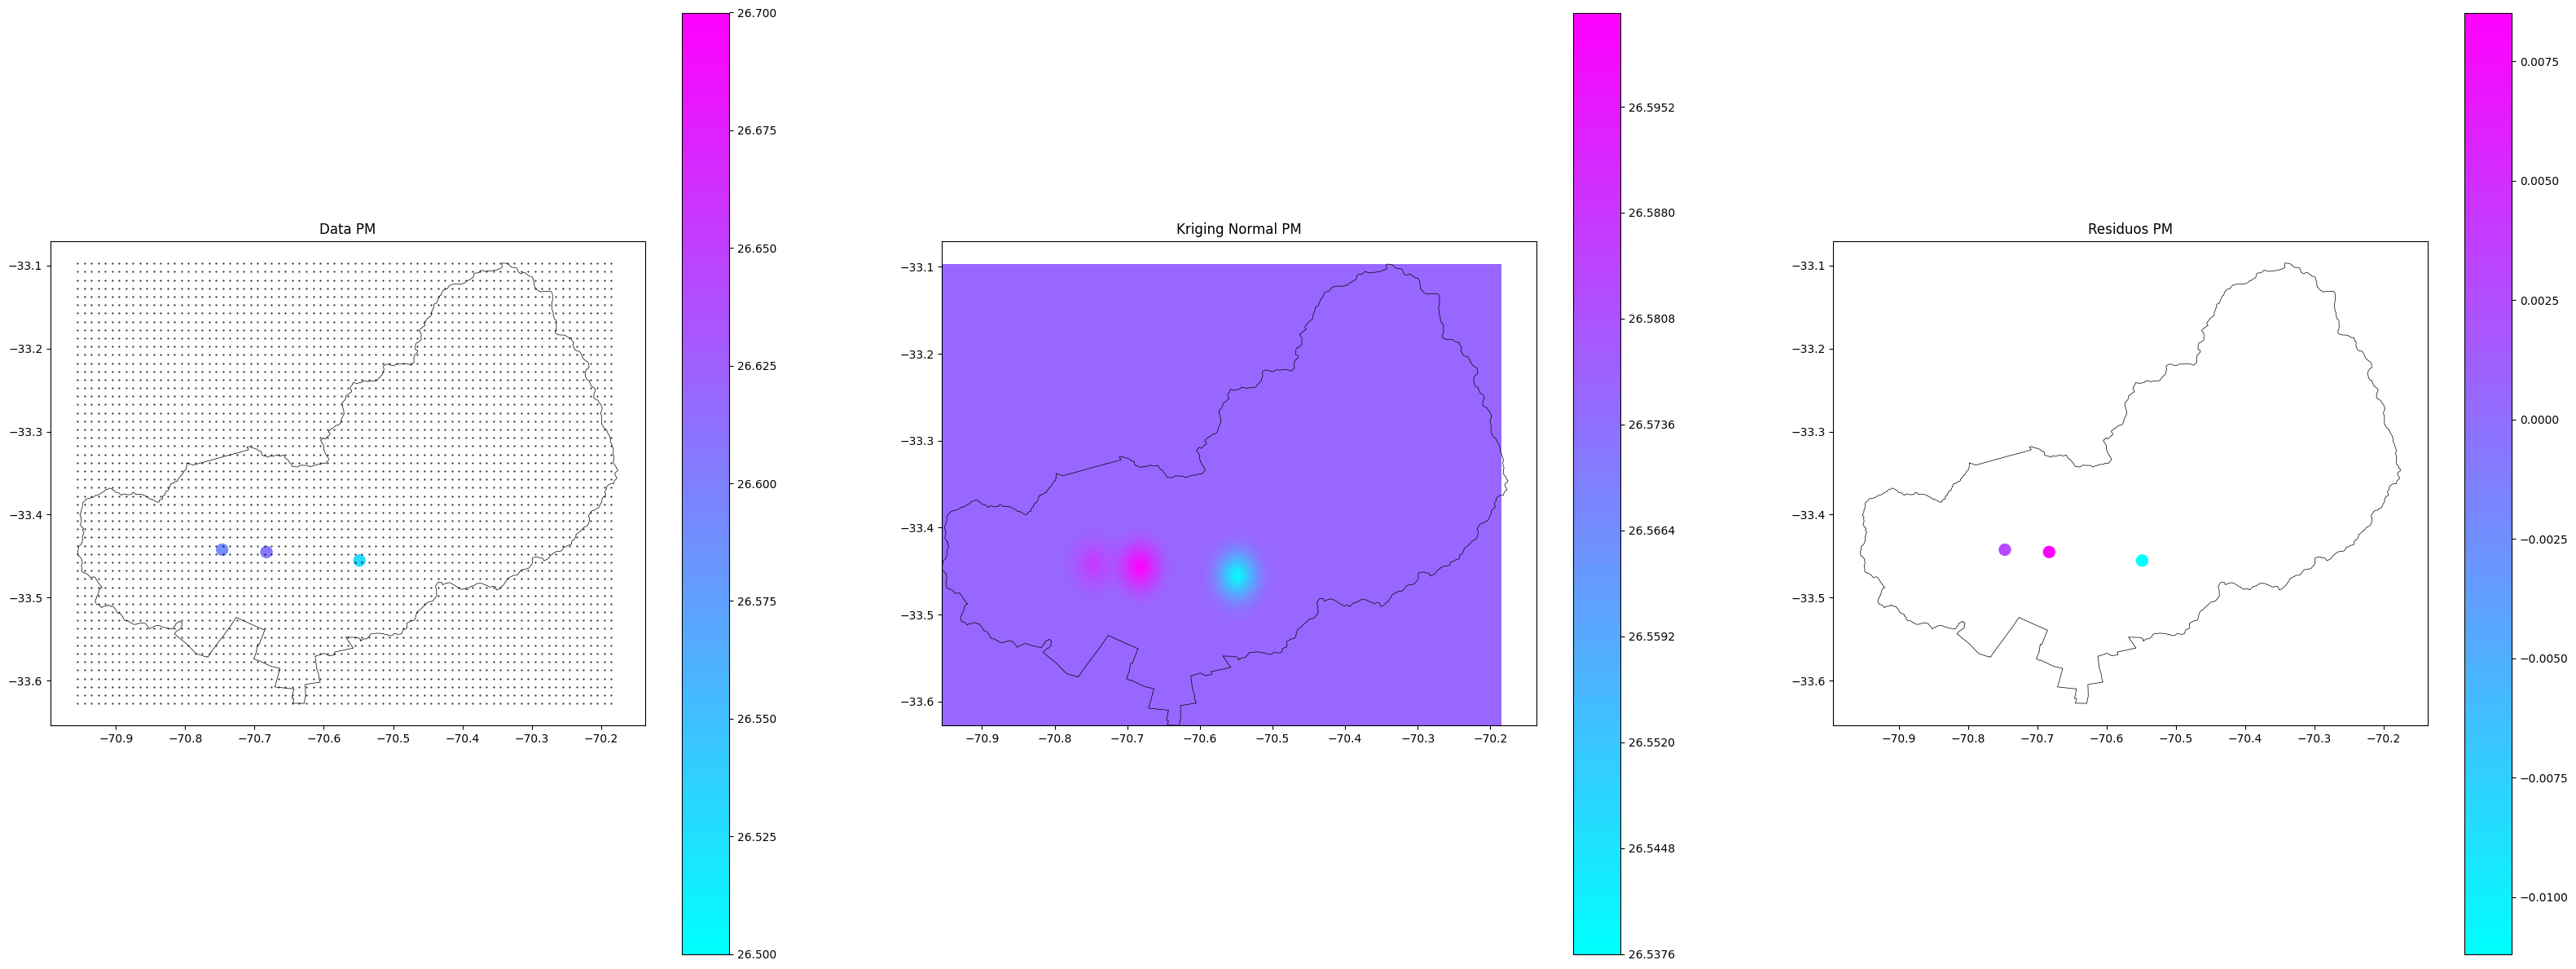

In [236]:
OK = OrdinaryKriging(lons, lats, t_PM, variogram_model='spherical', verbose=False, enable_plotting=False)
z1, ss1 = OK.execute('grid', xi, yi)

residuals = t_PM - np.array([z1.data[17][40], z1.data[18][28], z1.data[18][21]])

fig,(ax0,ax1, ax2)=plt.subplots(1,3,figsize=(40,15))

im=ax0.scatter(lons,lats,c=t_PM,cmap='cool',vmin=26.5,vmax=26.7, s = 100)
santiago.boundary.plot(ax=ax0,color='k',lw=0.5)
ax0.plot(xx, yy, marker='.', markersize=1,color='k', linestyle='none')
plt.colorbar(im,ax=ax0)
ax0.set_title('Data PM')

santiago.boundary.plot(ax=ax1,color='k',lw=0.5)
im1=ax1.contourf(xx,yy,z1, 100, cmap='cool', origin='lower')
plt.colorbar(im1,ax=ax1)
ax1.set_title('Kriging Normal PM');

santiago.boundary.plot(ax=ax2,color='k',lw=0.5)
im1=ax2.scatter(lons,lats,c=residuals,cmap='cool', s = 100)
plt.colorbar(im1,ax=ax2)
ax2.set_title('Residuos PM')

### Superficie

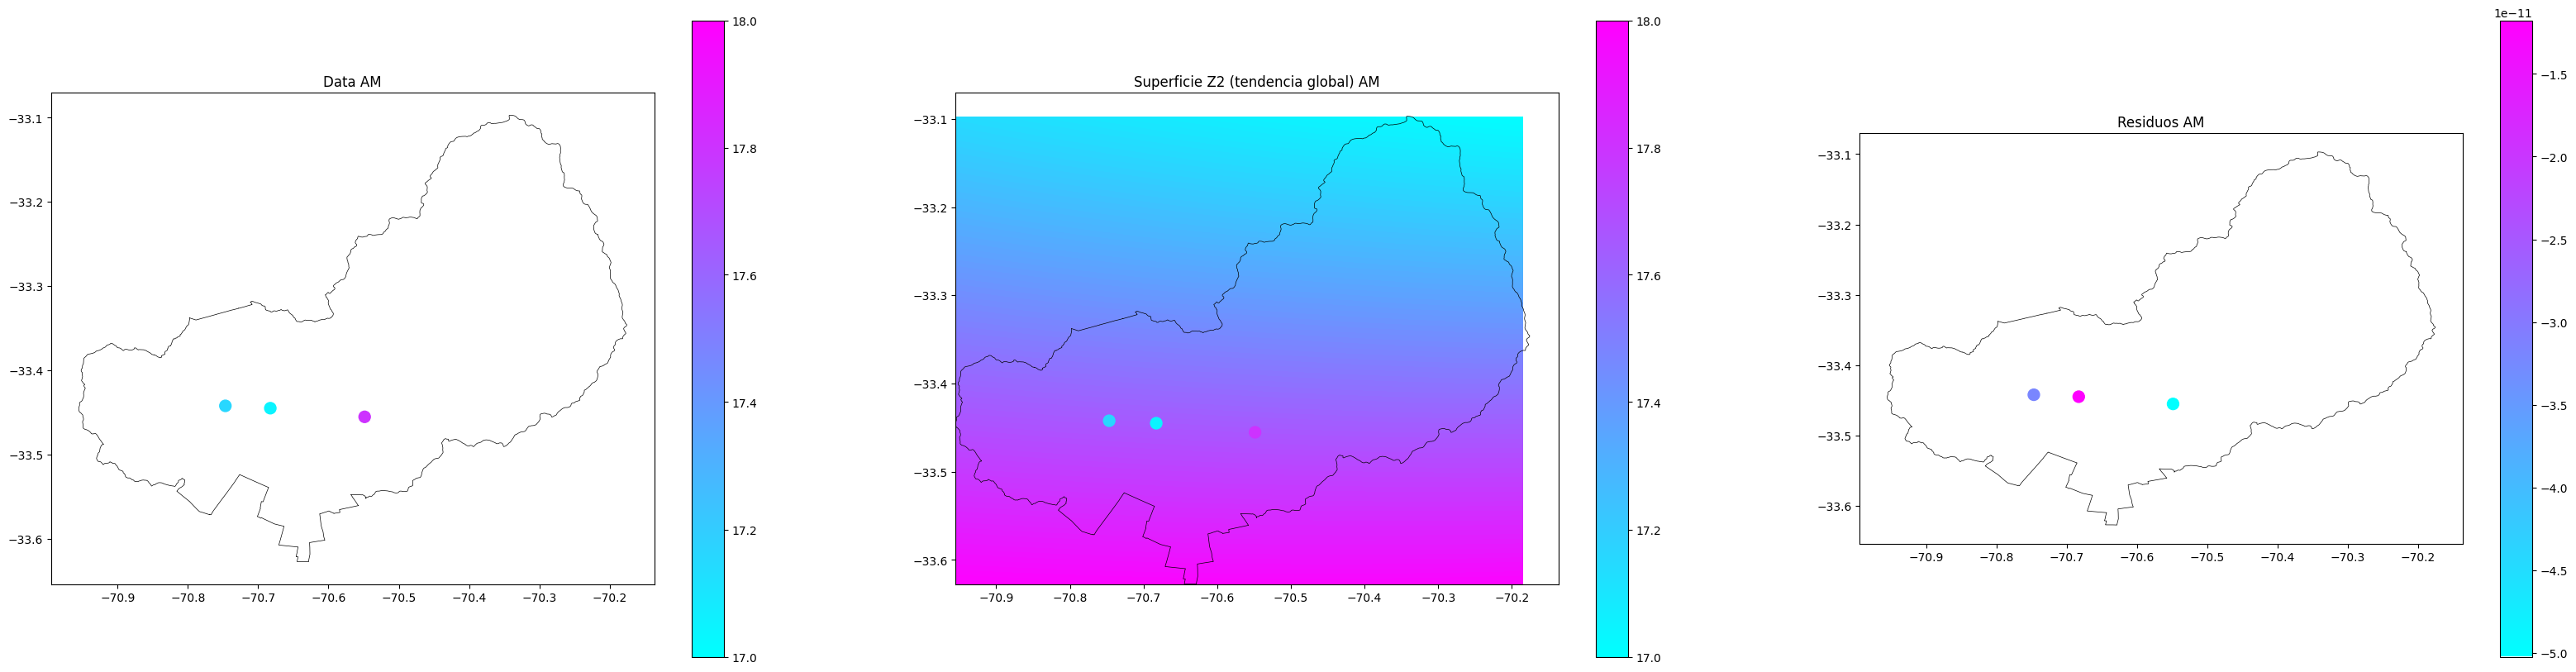

In [191]:
A = np.c_[lons, lats,lons**2,lats**2,lons*lats, np.ones(lons.shape[0])]
B = t_AM
C, r, rank, s = np.linalg.lstsq(A, B)

z_trend=C[0]*lons + C[1]*lats + C[2]*lons**2+C[3]*lats**2+C[4]*lons*lats+C[5]

Z2 = C[0]*xx + C[1]*yy + C[2]*xx**2+C[3]*yy**2+C[4]*xx*yy+C[5] #superficie interpolada

residuals=t_AM-z_trend

fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(40,10))

im=ax0.scatter(lons,lats,c=t_AM,cmap='cool',vmin=17,vmax=18, s = 100)
santiago.boundary.plot(ax=ax0,color='k',lw=0.5)
plt.colorbar(im,ax=ax0)
ax0.set_title('Data AM')

santiago.boundary.plot(ax=ax1,color='k',lw=0.5)
ax1.contourf(xx,yy,Z2, 100, cmap='cool', origin='lower')
im1=ax1.scatter(lons,lats,c=z_trend,cmap='cool',vmin=17,vmax=18, s = 100)

plt.colorbar(im1,ax=ax1)
ax1.set_title('Superficie Z2 (tendencia global) AM')

santiago.boundary.plot(ax=ax2,color='k',lw=0.5)
im1=ax2.scatter(lons,lats,c=residuals,cmap='cool', s = 100)
plt.colorbar(im1,ax=ax2)

ax2.set_aspect('equal')
ax2.set_title('Residuos AM');

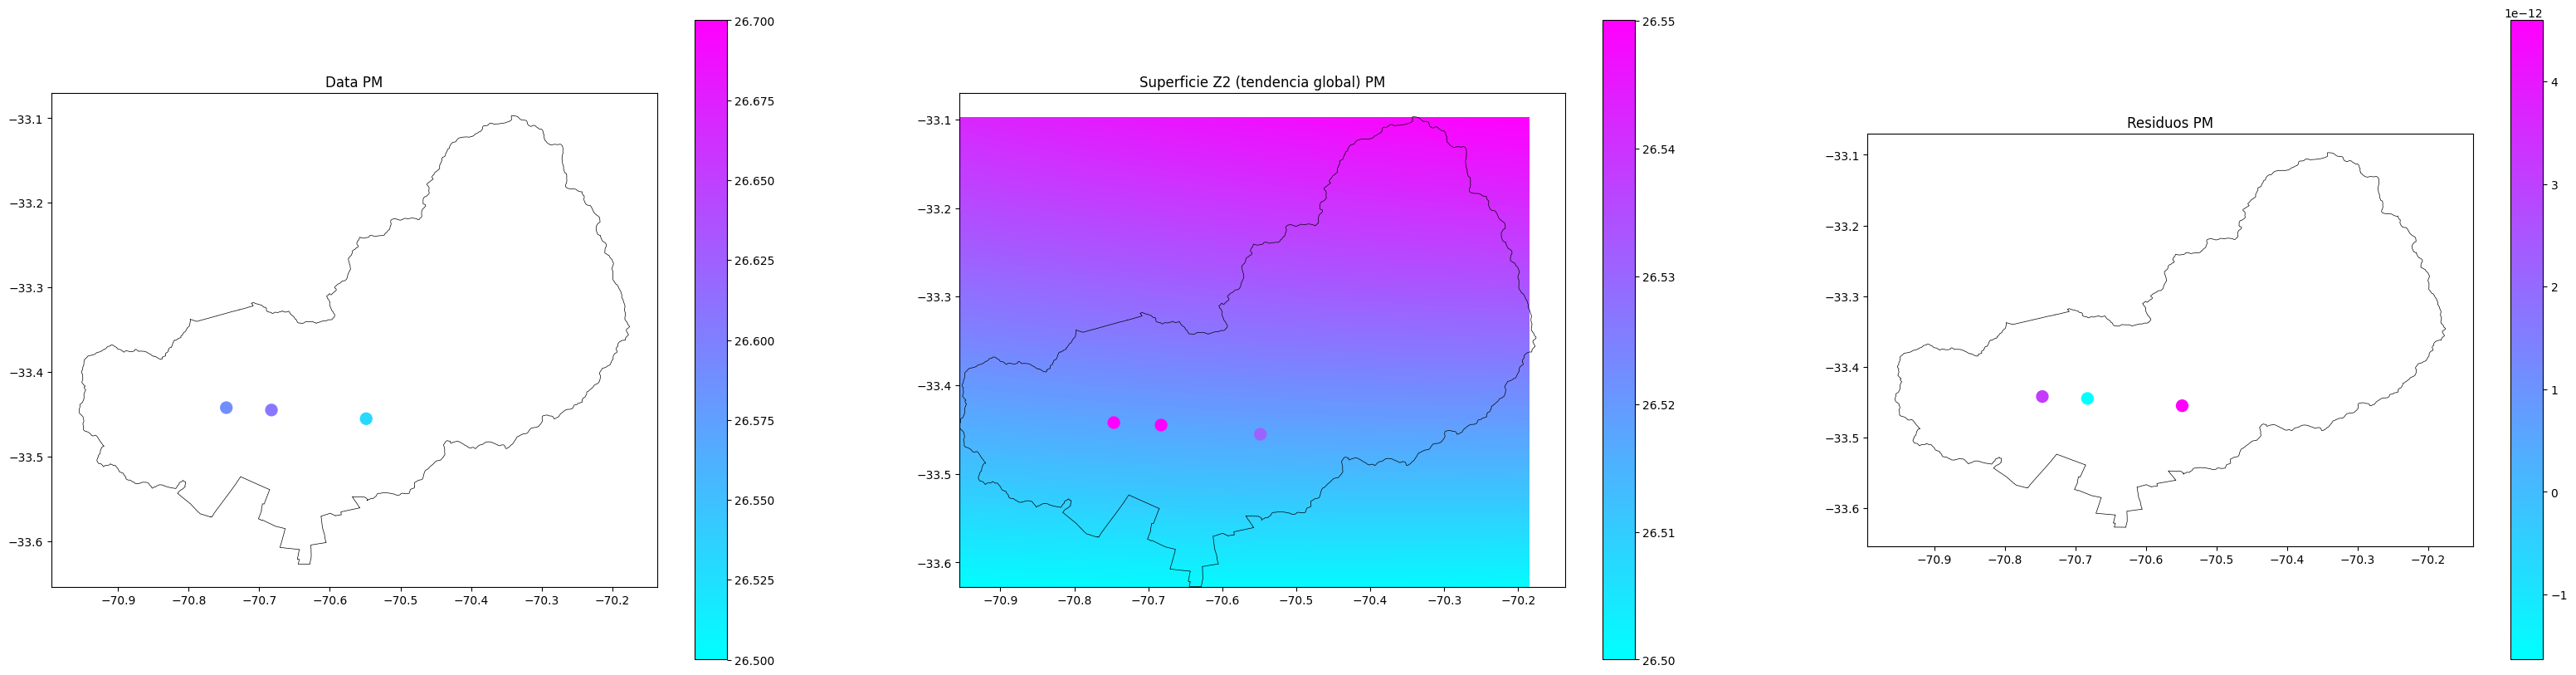

In [192]:
A = np.c_[lons, lats,lons**2,lats**2,lons*lats, np.ones(lons.shape[0])]
B = t_PM
C, r, rank, s = np.linalg.lstsq(A, B)

z_trend=C[0]*lons + C[1]*lats + C[2]*lons**2+C[3]*lats**2+C[4]*lons*lats+C[5]

Z2 = C[0]*xx + C[1]*yy + C[2]*xx**2+C[3]*yy**2+C[4]*xx*yy+C[5] #superficie interpolada

residuals=t_PM-z_trend

fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(40,10))

im=ax0.scatter(lons,lats,c=t_PM,cmap='cool',vmin=26.5,vmax=26.7, s = 100)
santiago.boundary.plot(ax=ax0,color='k',lw=0.5)
plt.colorbar(im,ax=ax0)
ax0.set_title('Data PM')

santiago.boundary.plot(ax=ax1,color='k',lw=0.5)
ax1.contourf(xx,yy,Z2, 100, cmap='cool', origin='lower')
im1=ax1.scatter(lons,lats,c=z_trend,cmap='cool',vmin=26.5,vmax=26.55, s = 100)

plt.colorbar(im1,ax=ax1)
ax1.set_title('Superficie Z2 (tendencia global) PM')

santiago.boundary.plot(ax=ax2,color='k',lw=0.5)
im1=ax2.scatter(lons,lats,c=residuals,cmap='cool', s = 100)
plt.colorbar(im1,ax=ax2)

ax2.set_aspect('equal')
ax2.set_title('Residuos PM');

### Proximidad

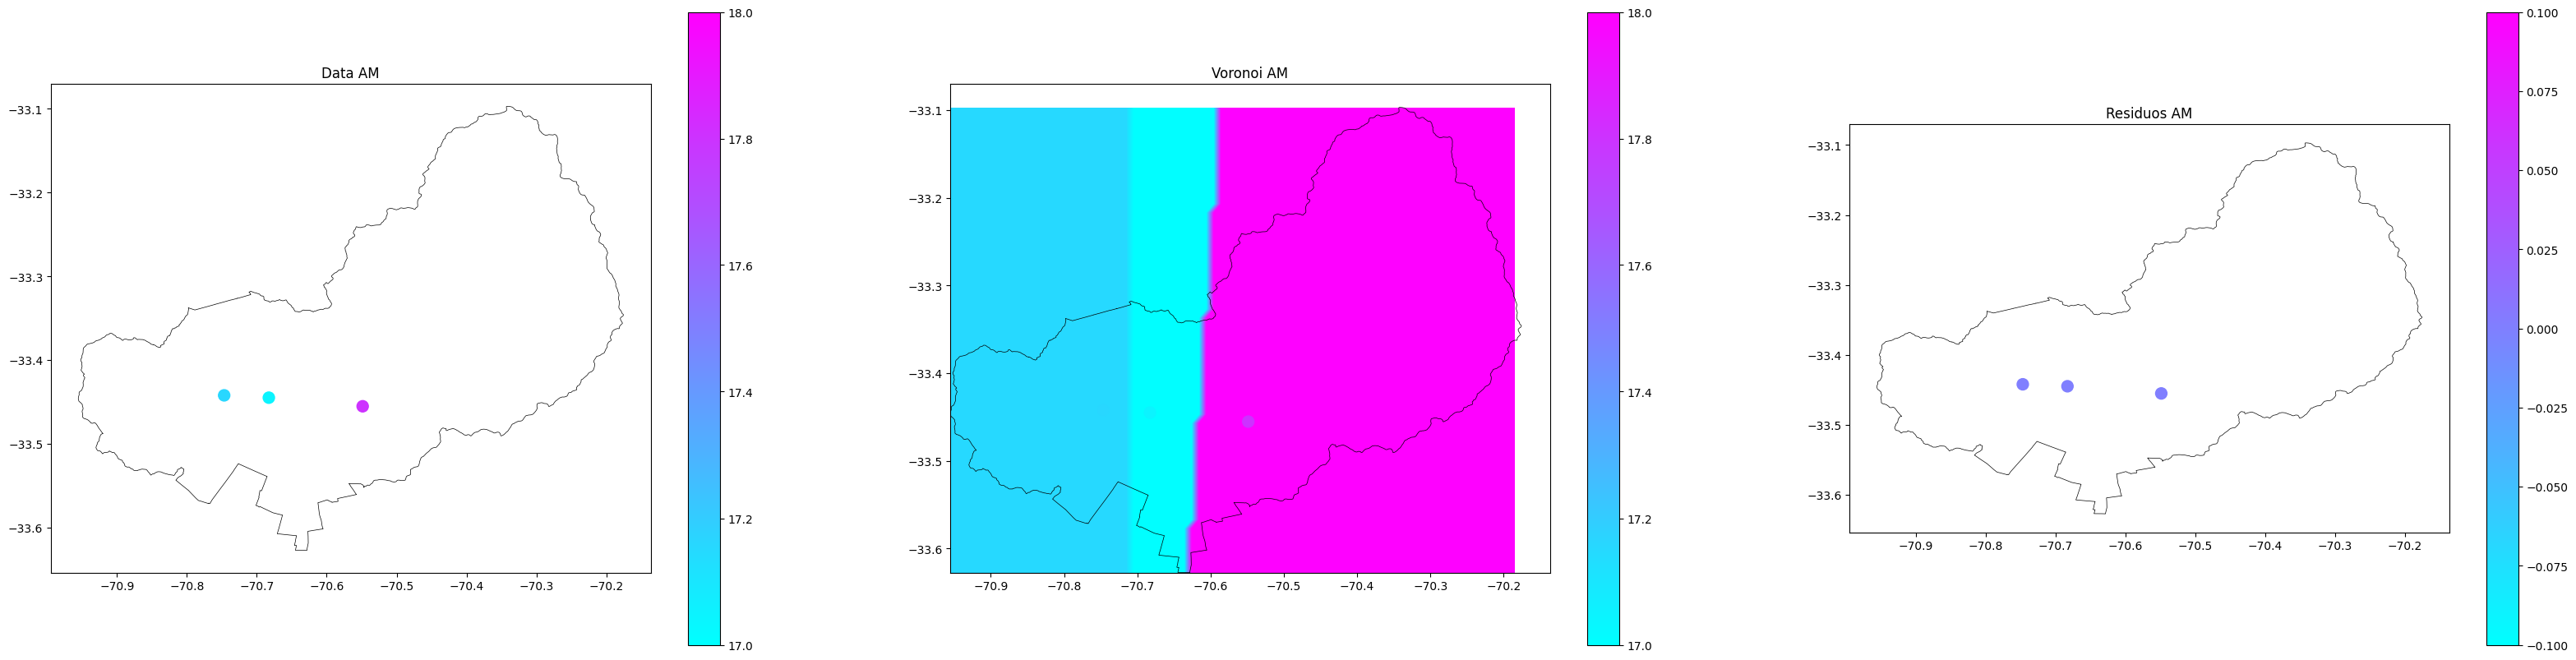

In [247]:
z = np.zeros((54, 78))

for i in range(54):
    for j in range(78):
        d1 = (17- i)**2 + (40-j)**2
        d2 = (18- i)**2 + (28-j)**2
        d3 = (18- i)**2 + (21-j)**2
        if d1 < d2 and d1 <d3:
            z[i][j] = t_AM[0]
        elif d2 < d1 and d2 <d3:
            z[i][j] = t_AM[1]
        else:
            z[i][j] = t_AM[2]

fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(40,10))

im=ax0.scatter(lons,lats,c=t_AM,cmap='cool',vmin=17,vmax=18, s = 100)
santiago.boundary.plot(ax=ax0,color='k',lw=0.5)
plt.colorbar(im,ax=ax0)
ax0.set_title('Data AM')

santiago.boundary.plot(ax=ax1,color='k',lw=0.5)
ax1.contourf(xx,yy,z, 100, cmap='cool', origin='lower')
im1=ax1.scatter(lons,lats,c=t_AM,cmap='cool',vmin=17,vmax=18, s = 100)

plt.colorbar(im1,ax=ax1)
ax1.set_title('Voronoi AM')

santiago.boundary.plot(ax=ax2,color='k',lw=0.5)
im1=ax2.scatter(lons,lats,c=[0,0,0],cmap='cool', s = 100)
plt.colorbar(im1,ax=ax2)

ax2.set_aspect('equal')
ax2.set_title('Residuos AM');

In [248]:
t_PM

array([26.53082026, 26.60624244, 26.58905466])

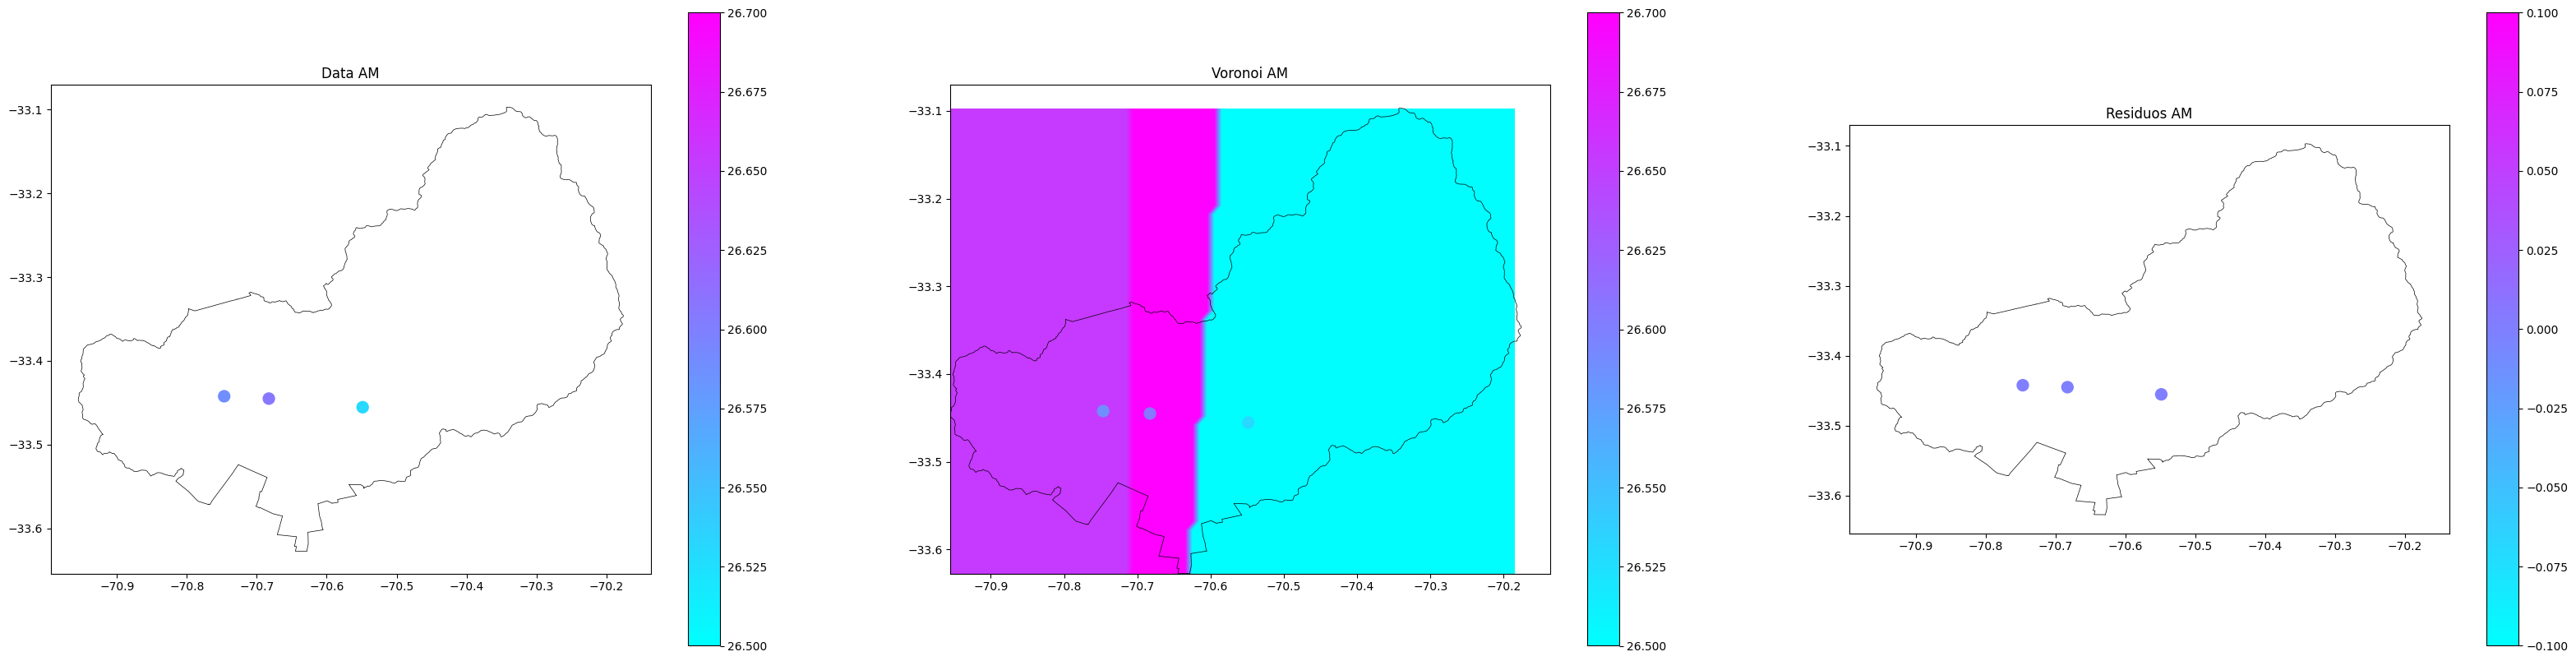

In [246]:
z = np.zeros((54, 78))

for i in range(54):
    for j in range(78):
        d1 = (17- i)**2 + (40-j)**2
        d2 = (18- i)**2 + (28-j)**2
        d3 = (18- i)**2 + (21-j)**2
        if d1 < d2 and d1 <d3:
            z[i][j] = t_PM[0]
        elif d2 < d1 and d2 <d3:
            z[i][j] = t_PM[1]
        else:
            z[i][j] = t_PM[2]

fig,(ax0,ax1,ax2)=plt.subplots(1,3,figsize=(40,10))

im=ax0.scatter(lons,lats,c=t_PM,cmap='cool',vmin=26.5,vmax=26.7, s = 100)
santiago.boundary.plot(ax=ax0,color='k',lw=0.5)
plt.colorbar(im,ax=ax0)
ax0.set_title('Data PM')

santiago.boundary.plot(ax=ax1,color='k',lw=0.5)
ax1.contourf(xx,yy,z, 100, cmap='cool', origin='lower')
im1=ax1.scatter(lons,lats,c=t_PM,cmap='cool',vmin=26.5,vmax=26.7, s = 100)

plt.colorbar(im1,ax=ax1)
ax1.set_title('Voronoi PM')

santiago.boundary.plot(ax=ax2,color='k',lw=0.5)
im1=ax2.scatter(lons,lats,c=[0,0,0],cmap='cool', s = 100)
plt.colorbar(im1,ax=ax2)

ax2.set_aspect('equal')
ax2.set_title('Residuos PM');

En general todos interpolaron bien. Voronoi resultó con residuos igual a 0 por definición. SIn embargo, considero que tendencia global es mejor ya que interpola más suavemente y tiene residuo menor. Sin embargo, kriging tiene una distribucion más razonable dado el contexto del problema.

Comparando con la imagen de raster, es posible evidenciar que esta última es mucho mejor definiendo las temperaturas. Esto se debe a que la interpolación solo se está haciendo con 3 puntos, lo que es bastante malo. Adicionalmente, la imagen tiene más variabilidad en sus max/min, ya que la obtenida interpolando no se mueve mucho de los valores de las estaciones, por lo que no alcanzan valores muy bajos de temperatura. Finalmente, todas las interpolaciones son mucho más parejas (sin tanta variación) entre lugares cercanos. Esto no se cumple en la imagen de raster ya que hay lugares con sombra, lugares donde llega directamente el sol, etc.

### 2. Análisis de patrones de temperatura. [12 ptos]


**2.1 [6 ptos]** Analice los datos de temperatura superficial  para el verano 2022-2023.

Para que los cálculos no sean tan pesados, he usado las comunas de santiago como las regiones a estudiar.

In [22]:
def temp_prom(geo):
    xy_ran = geo
    obj = mapping(xy_ran)
    ao = ee.Geometry.Polygon(obj['coordinates'])
    return para.clip(ao).reduceRegion(reducer = ee.Reducer.mean(), geometry = ao, scale = 30, maxPixels = 1e9).getInfo()

def NDVI_prom(geo):
    xy_ran = geo
    obj = mapping(xy_ran)
    ao = ee.Geometry.Polygon(obj['coordinates'])
    return ndvi.clip(ao).reduceRegion(reducer = ee.Reducer.mean(), geometry = ao, scale = 30, maxPixels = 1e9).getInfo()

In [23]:
#Lectura de datos
san_2 = gpd.read_file('Data_extra/COMUNA_C17.shp').to_crs(4326)
comuna = san_2[san_2['NOM_PROVIN'] == 'SANTIAGO']

#Calcular temperatura (y NDVI) promedio por comuna, esto toma un tiempo
comuna['Temp'] = comuna['geometry'].apply(temp_prom)
comuna['NDVI'] = comuna['geometry'].apply(NDVI_prom)

In [24]:
def get_temp(d):
    return float(d['therm'])

def get_ndvi(d):
    return float(d['NDVI'])

comuna['Temp'] = comuna['Temp'].apply(get_temp)
comuna['NDVI'] = comuna['NDVI'].apply(get_ndvi)

In [41]:
#Código de clases
w_rook = weights.contiguity.Rook.from_dataframe(comuna)
w_rook.transform = "R"
moran = esda.moran.Moran(comuna['Temp'], w_rook)

w_queen = weights.contiguity.Queen.from_dataframe(comuna)
w_rook = weights.contiguity.Rook.from_dataframe(comuna)
w_knn = weights.KNN.from_dataframe(comuna,k=3)
w_dist_1km = weights.DistanceBand.from_dataframe(comuna, 10000)

W={'Queen':w_queen,'Rook':w_rook,'KNN':w_knn,'Dist':w_dist_1km}

In [42]:
for kw in W.keys():
     
    w=W[kw]
    w.transform ='R'
    
    mean=comuna['Temp'].mean()
    std=comuna['Temp'].std()
    normed=(comuna['Temp']-mean)/std

    comuna['%s_norm Temp']=normed

    w_lag = weights.lag_spatial(w, normed)
    comuna['slag_%s_%s'%(kw,'Temp')] = weights.lag_spatial(w, normed)

    mean=comuna['NDVI'].mean()
    std=comuna['NDVI'].std()
    normed=(comuna['NDVI']-mean)/std
    
    comuna['%s_norm NDVI']=normed

    w_lag = weights.lag_spatial(w, normed)
    comuna['slag_%s_%s'%(kw,'NDVI')] = weights.lag_spatial(w, normed)

Slope: 0.5784062507792932
Slope: 0.5794807525686745
Slope: 0.5441522684332106
Slope: -0.03225806451612903


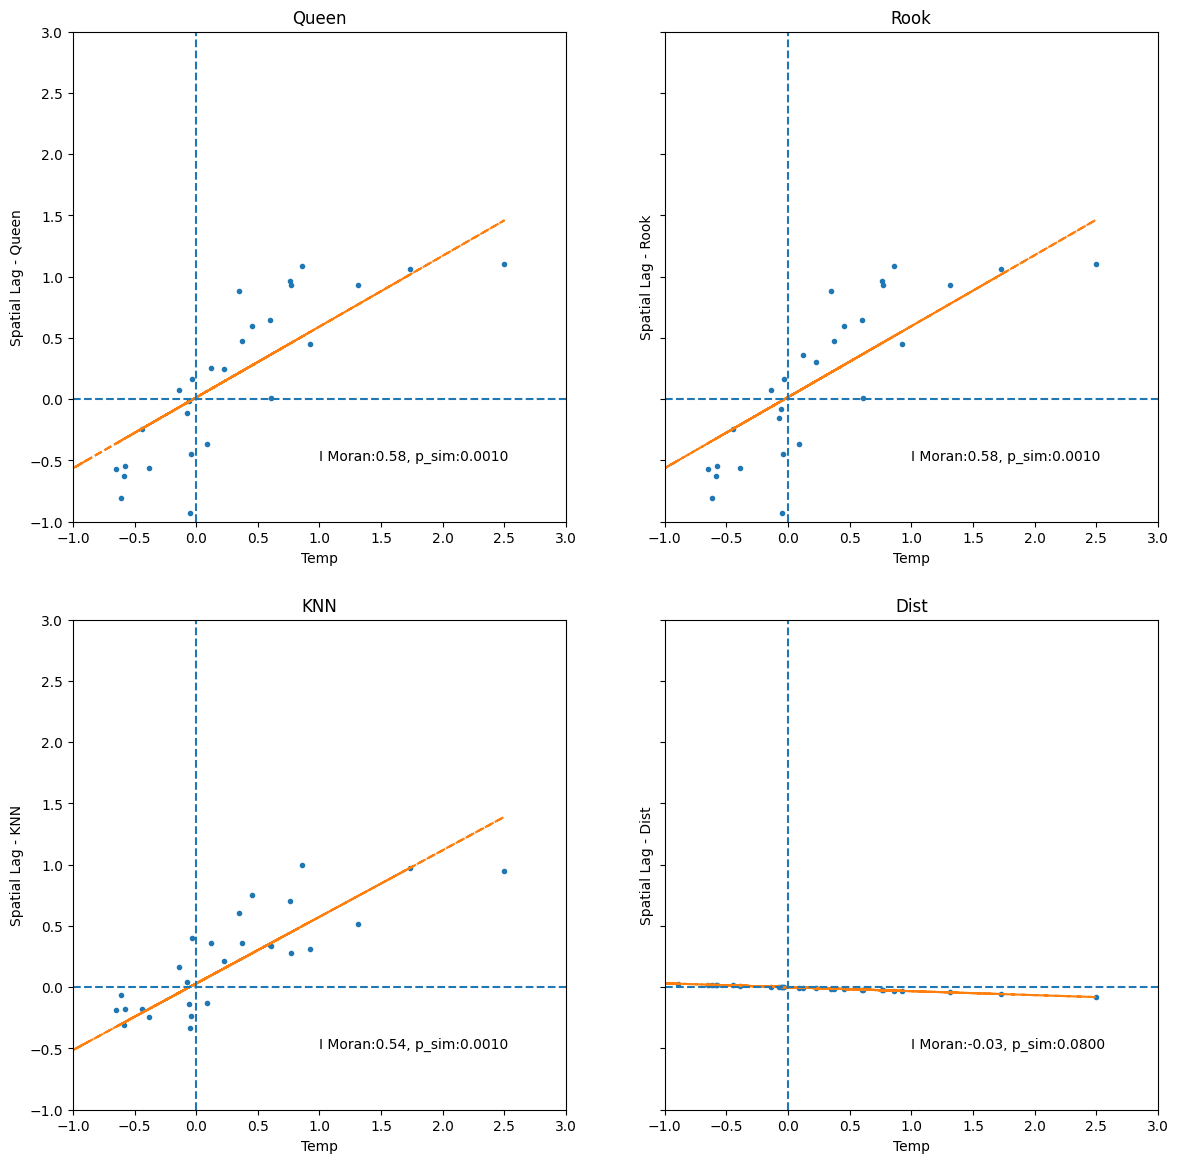

In [43]:
f,axes = plt.subplots(2,2,sharey=True)
f.set_size_inches(14,14)
axs=[axes[0][0],axes[0][1],axes[1][0],axes[1][1]]

for kw,ax in zip(W.keys(),axs):
    w=W[kw]
    x=comuna['%s_norm Temp']
    y=comuna['slag_%s_%s'%(kw,'Temp')]
    
    m,b= np.polyfit(x, y, 1)
    print('Slope:',m)
    ax.plot(x,y,'.')
    ax.plot(x,m*x+b,ls='--')
    ax.set_xlabel('Temp')
    ax.set_ylabel('Spatial Lag - %s' %kw)
    ax.set_xlim(-1,3)
    ax.set_ylim(-1,3)
    ax.set_title(kw)
    ax.axhline(y=0,ls='--')
    ax.axvline(x=0,ls='--')

    
    mi = esda.moran.Moran(x, w)
    ax.text(1,-0.5,'I Moran:%.2f, p_sim:%.4f'%(mi.I,mi.p_sim))

Como se aprecia, usar el método dist fue el único caso que entregó malos resultados, sin embargo, esto puede ser por una elección erronea del parámetro distancia de este método. De todas formas, los otros tipo de matrices entregaron buenos resultados, con relativo buen índice de Moran.

In [45]:
#Solo se hará para la matriz Queen
w=W['Queen']
x=comuna['%s_norm Temp']
y=comuna['slag_%s_%s'%(kw,'Temp')]

lisa = esda.moran.Moran_Local(x, w)

In [46]:
hh = []
hl = []
ll = []
lh = []
otros = []
#Valor P menor a 0.05 (significancia 95%)
for i in range(32):
    if lisa.q[i] == 1 and lisa.p_sim[i] < 0.05:
        hh.append(i)
    elif lisa.q[i] == 2 and lisa.p_sim[i] < 0.05:
        hl.append(i)
    elif lisa.q[i] == 3 and lisa.p_sim[i] < 0.05:
        ll.append(i)
    elif lisa.q[i] == 4 and lisa.p_sim[i] < 0.05:
        lh.append(i)
    else:
        otros.append(i)

df_hh = comuna.iloc[hh]
df_hl = comuna.iloc[hl]
df_ll = comuna.iloc[ll]
df_lh = comuna.iloc[lh]
df_otros = comuna.iloc[otros]

In [47]:
print(len(lh))
print(len(hl))

0
0


No hay casos Low-High o caso High-Low, por lo que no los graficaremos.

Text(0.5, 1.0, 'Hot y Cold spots de temperatura Santiago')

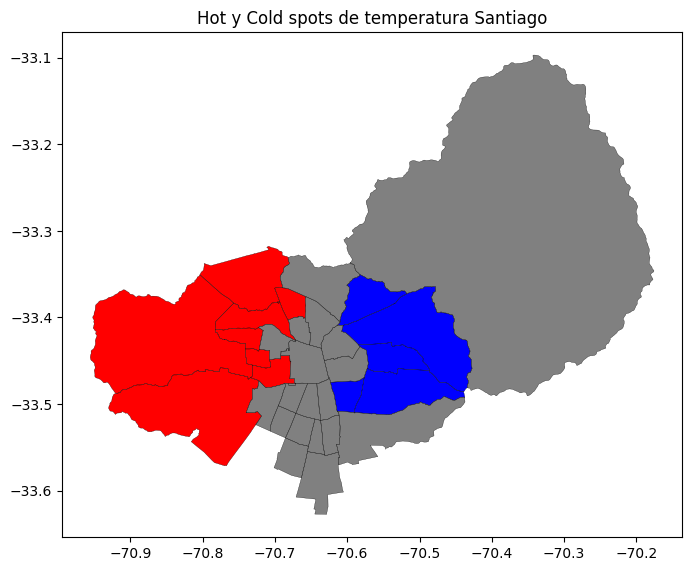

In [48]:
f, ax = plt.subplots(1, figsize=(8,8))

df_hh.plot(ax=ax, column='Temp',color='red', linewidth=0.4,legend=True)
df_ll.plot(ax=ax, column='Temp',color='blue', linewidth=0.4,legend=True)
df_otros.plot(ax=ax, column='Temp',color='gray', linewidth=0.4,legend=True)

comuna.boundary.plot(ax=ax, color='black',linewidth=0.2,label='Zonas')
ax.set_title('Hot y Cold spots de temperatura Santiago')

Aca, las regiones rojas son el caso HH con 95% de significancia, y los azules son LL con igual significancia.

**2.2 [6 ptos]** Los estudios de islas urbanas de calor, apuntan en general a identificar patrones espacio temporales de temperatura superficial, y también a identificar los factores explicativos de dichos patrones. Por ejemplo, es usual analizar también la distribución de variables como NDVI, NBI y la elevación, obtenida de modelos de elevación digital o DEM (como ejemplos, Eshetie 2024). 

Ya se hicieron gran parte de los cálculos. He elegido NDVI ya que las zonas con más vegetación deberían tener menor temperatura.

In [53]:
#Mapa
Map = geemap.Map(center=[0.5 * (miny + maxy),0.5 * (minx + maxx)], zoom=10)

vis_params = {"min": 0, "max": 0.5 , 'palette': cm.palettes.BrBG}

Map.addLayer(ndvi, vis_params,name='Imagen')

Map

Map(center=[-33.362209971499965, -70.56555456249995], controls=(WidgetControl(options=['position', 'transparen…

Las secciones en verde tienen mayor NDVI que las en color cafe.

Text(0.5, 1.0, 'Hot y Cold spots NDVI Santiago')

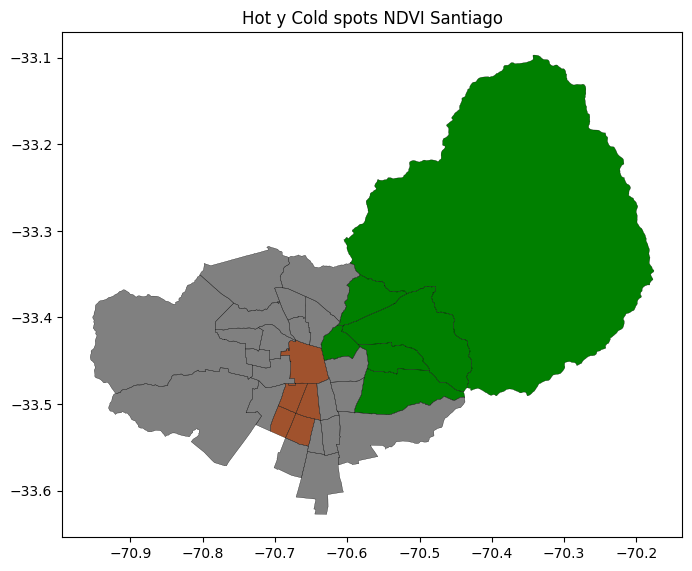

In [56]:
#Cálculo correlación

w=W['Queen']
x=comuna['%s_norm NDVI']
y=comuna['slag_%s_%s'%(kw,'NDVI')]

lisa = esda.moran.Moran_Local(x, w)

hh = []
hl = []
ll = []
lh = []
otros = []
for i in range(32):
    if lisa.q[i] == 1 and lisa.p_sim[i] < 0.05:
        hh.append(i)
    elif lisa.q[i] == 2 and lisa.p_sim[i] < 0.05:
        hl.append(i)
    elif lisa.q[i] == 3 and lisa.p_sim[i] < 0.05:
        ll.append(i)
    elif lisa.q[i] == 4 and lisa.p_sim[i] < 0.05:
        lh.append(i)
    else:
        otros.append(i)

df_hh = comuna.iloc[hh]
df_hl = comuna.iloc[hl]
df_ll = comuna.iloc[ll]
df_lh = comuna.iloc[lh]
df_otros = comuna.iloc[otros]

f, ax = plt.subplots(1, figsize=(8,8))

df_hh.plot(ax=ax, column='NDVI',color='green', linewidth=0.4,legend=True)
df_ll.plot(ax=ax, column='NDVI',color='sienna', linewidth=0.4,legend=True)
df_otros.plot(ax=ax, column='NDVI',color='gray', linewidth=0.4,legend=True)

comuna.boundary.plot(ax=ax, color='black',linewidth=0.2,label='Zonas')
ax.set_title('Hot y Cold spots NDVI Santiago')

Las regiones verdes son las HH y las marrón son LL. Contrastando con el gráfico anterior, no se evidencia mucha correlación entre las zonas LL y HH de cada gráfico, lo que no va acorde a nuestra hipótesis. En conclusión, al menos este estudio no arroja correlación entre LST y NDVI.